In [1]:
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset -p /content/mango_leaf_disease --unzip

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 103M/103M [00:05<00:00, 22.7MB/s]
100% 103M/103M [00:05<00:00, 19.2MB/s]


In [2]:
base_dir = '/content/mango_leaf_disease'

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [4]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [5]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 116s 880ms/step - accuracy: 0.2621 - loss: 2.1455 - val_accuracy: 0.6375 - val_loss: 1.4103 - learning_rate: 1.0000e-05
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 122s 827ms/step - accuracy: 0.5528 - loss: 1.2534 - val_accuracy: 0.7588 - val_loss: 0.9447 - learning_rate: 1.0000e-05
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 140s 818ms/step - accuracy: 0.6966 - loss: 0.8972 - val_accuracy: 0.8313 - val_loss: 0.6472 - learning_rate: 1.0000e-05
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 821ms/step - accuracy: 0.7568 - loss: 0.7117 - val_accuracy: 0.8450 - val_loss: 0.5495 - learning_rate: 1.0000e-05
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 817ms/step - accuracy: 0.8098 - loss: 0.5988 - val_accuracy: 0.8850 - val_loss: 0.4236 - learning_rate: 1.0000e-05
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 820ms/step - accuracy: 0.8410 - loss: 0.4898 - val_accuracy: 0.8813 - val_loss: 0.4067 - learning_rate: 1.0000e-05
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 143s 813ms/st

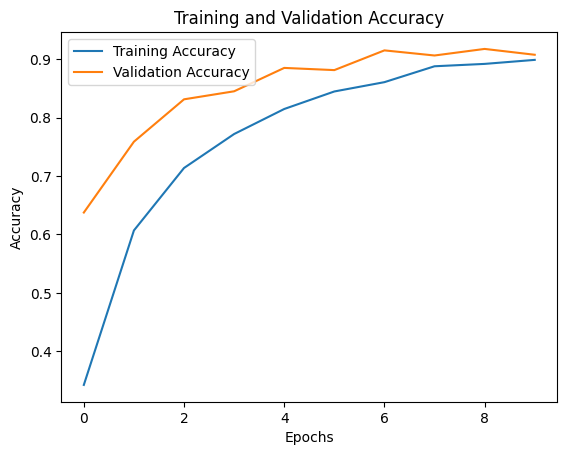

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='upper left')
plt.show()